# <center> Saturation vapour pressure functions

**Goal of the notebook:**
Investigate the different saturation vapour pressure functions available in Air Sea Flux code for the COARE 3.5 parameterization



**Motivation:**
The choice of the function has a significant effect for the latent heat flux and q10n for the S88 paramaterization (see table S15): is it the same for COARE 3.5?


***What is the saturation vapour pressure function?***

The saturation vapour pressure function $e_s$ is used to compute the humidity when the humidity input is given by a relative humidy percentage or a dewpoint temperature.

See equation S11 in the supplementary material.

***What is the default method?***

Buck method (2012)

***What are the different methods available?***

There are 13 formulations for $e_s$ in AirSeaFluxCode.

***What is reported in Biri et al. 2023 regarding the quantification of the effect of $e_s$ used?***

In Biri et al. (2023), they investigate: 
- the impact of another $e_s$ formulation (WMO (2018) in comparison to the default one (Buck (2012)) formulation - for the 10 different parameterisations (C35, S80, ...)
- the impact of the 12 alternative formulations in comparison to the default one (Buck (2012)) for the S88 formulation



# 1. Load the packages, AirSeaFluxCode and data 

In [12]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

In [13]:
# path to AirSeaFluxCode algorithm
sys.path.append('../../ms_thesis/AirSeaFluxCode/AirSeaFluxCode-master/AirSeaFluxCode/src/')

In [14]:
from AirSeaFluxCode import AirSeaFluxCode

In [15]:
# dataset from TARSAN 2022 cruise - ship data
ds_tarsan_2022 = pd.read_csv('../Data/TARSAN_2022/jgofs_30minmean_2022.csv')

# convert to datetime format for the plot 
ds_tarsan_2022['Time'] = pd.to_datetime(ds_tarsan_2022['Time'],format='%Y-%m-%d %H:%M:%S')

# 2. Compute the latent heat flux and humidity for the C35 parameterisation with different qmet 

Information about qmeth parameter:
>  qmeth : str
> >     is the saturation evaporation method to use amongst
            "HylandWexler","Hardy","Preining","Wexler","GoffGratch","WMO",
            "MagnusTetens","Buck","Buck2","WMO2018","Sonntag","Bolton",
            "IAPWS","MurphyKoop"]
             default is Buck2


In [16]:
# height of the sensors
hu = np.asarray(34.3408)
ht = np.asarray(19.2024)
hin = np.array([hu, ht, ht])

In [17]:
# list of the different formula to compute the saturation vapour pressure function
qmeth_array = ["HylandWexler","Hardy","Preining","Wexler","GoffGratch","WMO",
            "MagnusTetens","Buck","Buck2","WMO2018","Sonntag","Bolton",
            "IAPWS","MurphyKoop"]
             

In [18]:
# Loop to compute AirSeaFluxCode output for each qmeth
d = {qmeth: pd.DataFrame(AirSeaFluxCode(spd=np.asarray(ds_tarsan_2022['WindSpeed']),
               T=np.asarray(ds_tarsan_2022['AirTemp']),
               SST=np.asarray(ds_tarsan_2022['SST']),
               SST_fl='bulk',
               meth='C35',
               lat=np.asarray(ds_tarsan_2022['Lat']),
               hum=["rh",np.asarray(ds_tarsan_2022['RH'])],
               hin=hin,
               hout=10,
               Rl=np.asarray(ds_tarsan_2022['PIR']),
               Rs=np.asarray(ds_tarsan_2022['PSP']),
               cskin=1,
               skin="C35",
               wl=1,
               gust=[1,1.2,600,0.01], # x=1 follows Fairall et al. 2003 - ref paper for C35, beta,zi and ustb are the default parameters in ASFcode
               qmeth=qmeth,
               tol=['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1], #default
               maxiter=10, #default
               out=0, #default
               L="tsrv", #default
               out_var=['q10n','qsea','qair','latent']
              )) 
     for qmeth in qmeth_array}

# 3. Comparisons plot

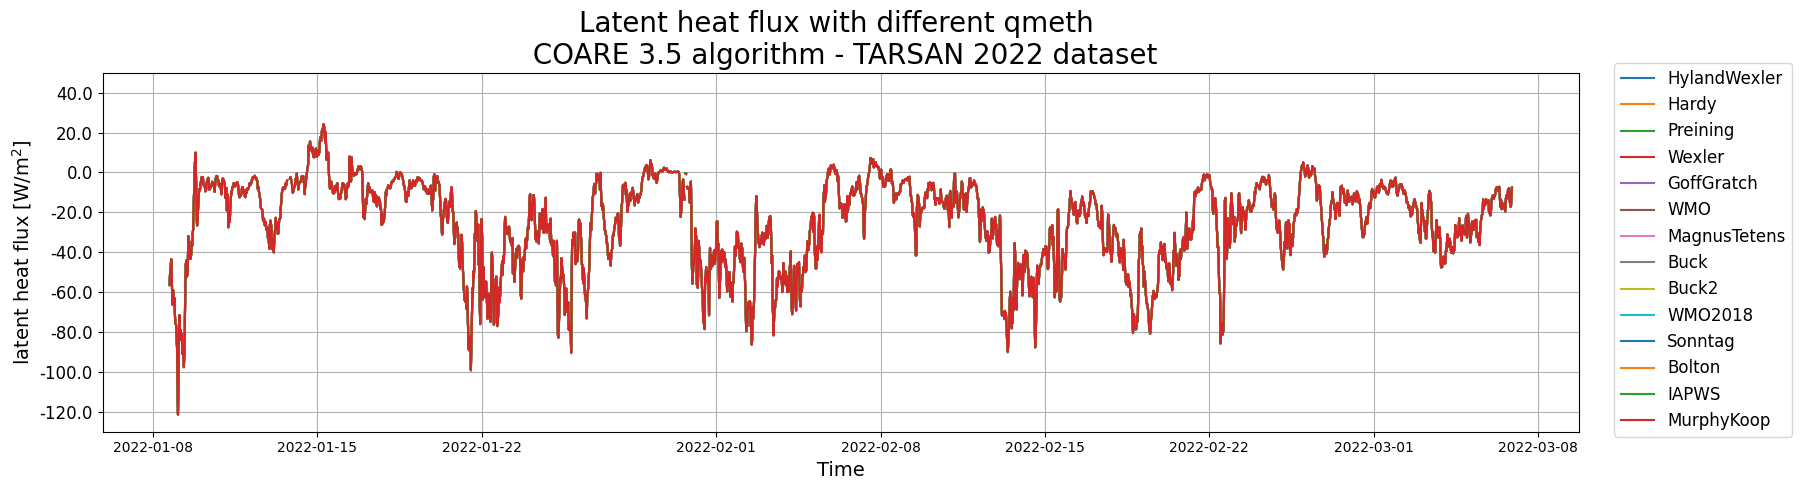

In [64]:
fig,ax= plt.subplots(nrows=1,ncols=1,figsize=(18,5))

for qmeth in d:
    ax.plot(ds_tarsan_2022['Time'],d[qmeth]['latent'],label=qmeth)
    
    
ax.legend(ncols=1,bbox_to_anchor=(1.15,1.05),fontsize=12)
ax.set_title('Latent heat flux with different qmeth \n COARE 3.5 algorithm - TARSAN 2022 dataset',fontsize=20)
ax.set_xlabel('Time',fontsize=14)

ax.set_ylabel('latent heat flux [W/m$^2$]',fontsize=14)
ax.set_yticklabels(labels=ax.get_yticks(),fontsize=12)


ax.set_ylim(-130,50)
ax.grid()


fig.tight_layout()



**Comment:** no differences visible. 

Let's take Buck2 as a reference and plot the latent heat flux (Buck 2) minus latent heat flux (other qmeth).

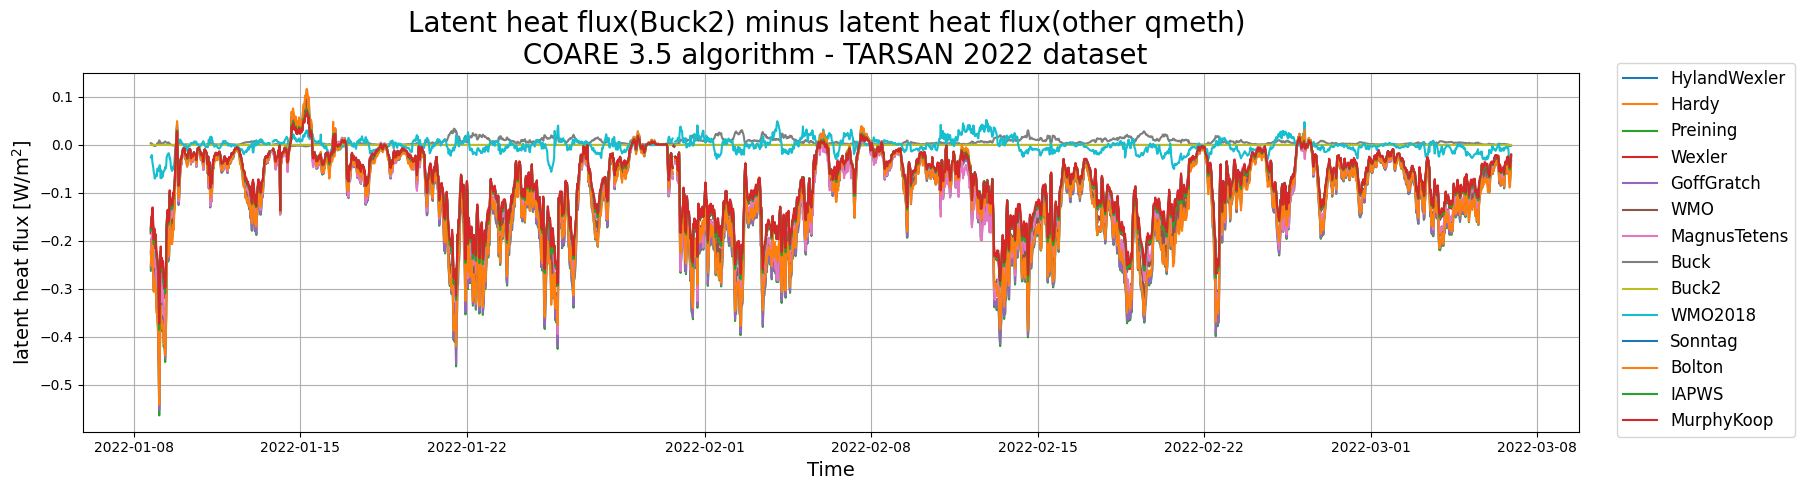

In [68]:
fig,ax= plt.subplots(nrows=1,ncols=1,figsize=(18,5))

for qmeth in d:
    ax.plot(ds_tarsan_2022['Time'],d['Buck2']['latent']-d[qmeth]['latent'],label=qmeth)

    
ax.legend(ncols=1,bbox_to_anchor=(1.15,1.05),fontsize=12)
ax.set_title('Latent heat flux(Buck2) minus latent heat flux(other qmeth) \n COARE 3.5 algorithm - TARSAN 2022 dataset',fontsize=20)
ax.set_xlabel('Time',fontsize=14)
ax.set_ylabel('latent heat flux [W/m$^2$]',fontsize=14)
#ax.set_ylim(-130,50)
ax.grid()
#ax.set_yticklabels(labels=ax.get_yticks(),fontsize=12)

fig.tight_layout()




In [19]:
# cf table 2 Biri et al. 2023 
tol_lhf= 0.1
significance_lhf = 2

# cf Results section - 2nd paragraph Biri et al. 2023
bins = [-10**10,-5*significance_lhf,-significance_lhf,-tol_lhf,-0.1*tol_lhf, 0.1*tol_lhf, tol_lhf,significance_lhf,5*significance_lhf,10**10]
bins_label = ['major effect (-)','significant effect (-)','insignificant effect (-)','negligible effect (-)','no effect','negligible effect (+)','insignificant effect (+)','significant effect (+)','major effect (+)']


In [28]:
for qmeth in d:
    print(qmeth + ' method compared to Buck2 method, number of values that have: \n')
    #print(bins_label)
    temp_stat = binned_statistic(d[qmeth]['latent']-d['Buck2']['latent'],d[qmeth]['latent']- d['Buck2']['latent'],
                             statistic='count', 
                             bins=bins)
    temp_data = {'Count': temp_stat.statistic}

    print(pd.DataFrame(index=bins_label,data=temp_data))
    print('--------------------------------------------')


HylandWexler method compared to Buck2 method, number of values that have: 

                           Count
major effect (-)             0.0
significant effect (-)       0.0
insignificant effect (-)     0.0
negligible effect (-)       75.0
no effect                  242.0
negligible effect (+)     1450.0
insignificant effect (+)   969.0
significant effect (+)       0.0
major effect (+)             0.0
--------------------------------------------
Hardy method compared to Buck2 method, number of values that have: 

                           Count
major effect (-)             0.0
significant effect (-)       0.0
insignificant effect (-)     0.0
negligible effect (-)       70.0
no effect                  249.0
negligible effect (+)     1477.0
insignificant effect (+)   940.0
significant effect (+)       0.0
major effect (+)             0.0
--------------------------------------------
Preining method compared to Buck2 method, number of values that have: 

                           Count
